<a href="https://colab.research.google.com/github/Suliman8/FYP-1/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your preprocessed UNSW-NB15 dataset CSV file...


Saving UNSW_NB15_preprocessed.csv to UNSW_NB15_preprocessed.csv
Processing file: UNSW_NB15_preprocessed.csv

Step 1: Loading the preprocessed UNSW-NB15 dataset...

Dataset shape before feature engineering: (175341, 65)
Number of rows: 175341
Number of columns: 65

Dataset column types:
id          int64
dur       float64
spkts     float64
dpkts     float64
sbytes    float64
dbytes    float64
rate      float64
sttl      float64
dttl      float64
sload     float64
dload     float64
sloss     float64
dloss     float64
sinpkt    float64
dinpkt    float64
sjit      float64
djit      float64
swin      float64
stcpb     float64
dtcpb     float64
dtype: object

Step 2: Creating new features based on domain knowledge...
✓ Created: total_bytes (sbytes + dbytes)
✓ Created: duration bins (short, medium, long)
⚠ Warning: 'proto' column not found
✓ Created: total_packets (spkts + dpkts)
✓ Created: packets_per_second
✓ Created: sbytes_to_dbytes_ratio
✓ Created: attack_freq (frequency of each attack t

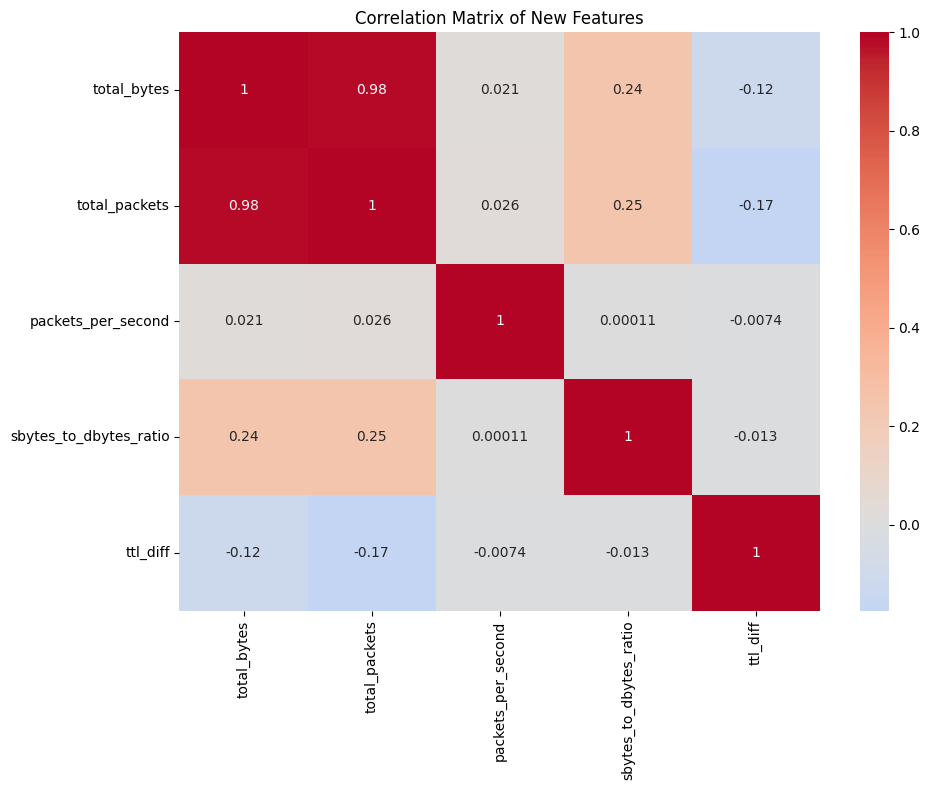


Step 4: Analyzing feature importance...

Top 20 most important features:


,Feature,Importance
69,attack_freq,0.334697
6,sttl,0.141329
28,ct_state_ttl,0.092156
9,dload,0.061898
55,state_INT,0.022386
7,dttl,0.021482
8,sload,0.020728
22,ackdat,0.020532
5,rate,0.018741
13,dinpkt,0.018722


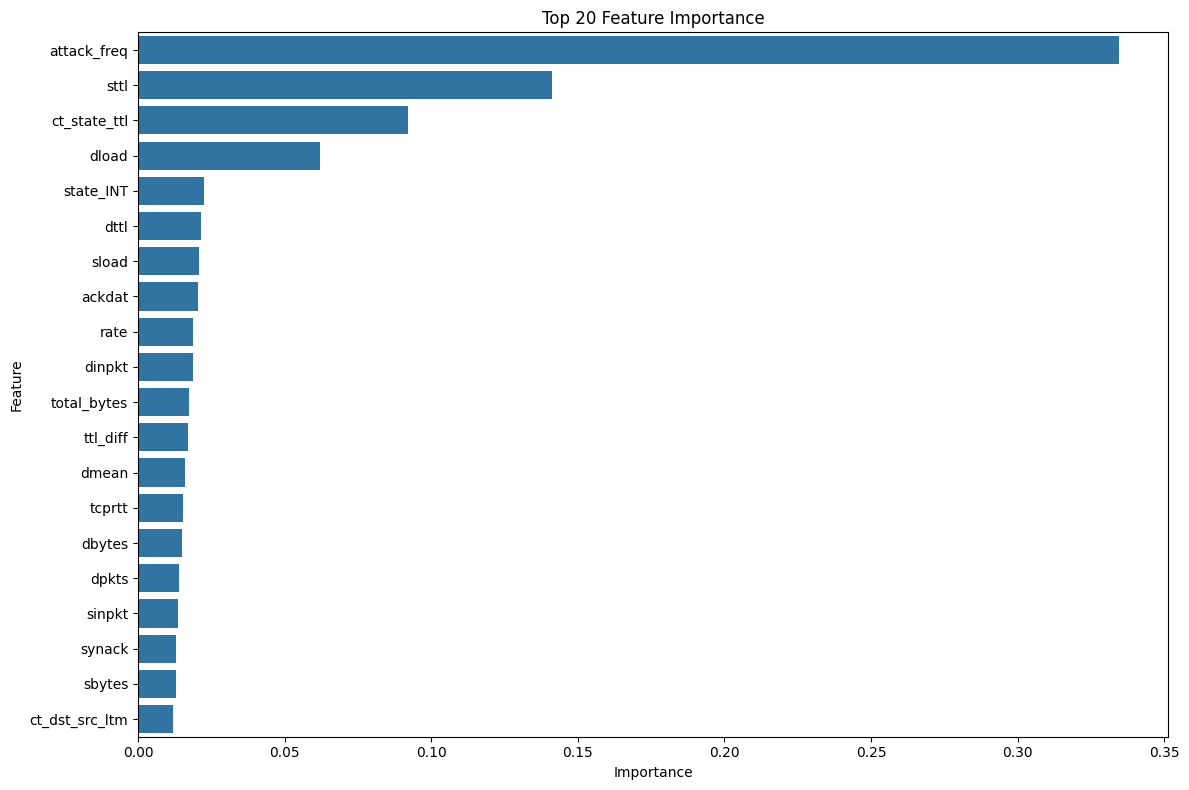


Step 5: Saving the engineered dataset...
Engineered dataset saved as 'UNSW_NB15_feature_engineered.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Step 6: Generating feature engineering summary...

UNSW-NB15 Dataset Feature Engineering Summary

1. Original Dataset Information
   - Number of rows: 175341
   - Number of columns: 65

2. Feature Engineering Applied
   - Combined features: total_bytes, total_packets
   - Duration bins: short (<1s), medium (1-10s), long (>10s)
   - Ratio features: sbytes_to_dbytes_ratio, packets_per_second
   - Binary flags: is_rare_proto
   - Network features: ttl_diff
   - Pattern features: service_diversity, state_transitions
   - Frequency features: attack_freq

3. Engineered Dataset Information
   - Number of rows: 175341 (unchanged)
   - Number of columns: 76
   - New features added: 11

4. Feature Correlation Analysis
   - Identified 17 highly correlated feature pairs
   - No redundant features removed (for flexibility)

5. Feature Importance Analysis
   - Random Forest used for feature ranking
   - Top 20 most important features displayed
   - Helps guide feature selection for models

6. Next 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature engineering completed successfully!
Your dataset now contains valuable engineered features that should improve model performance.
Next steps: Consider class imbalance handling and model training.


In [1]:
# Feature Engineering for UNSW-NB15 Dataset
# -----------------------------------------

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files
from IPython.display import display, HTML

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Upload the preprocessed dataset
print("Please upload your preprocessed UNSW-NB15 dataset CSV file...")
uploaded = files.upload()

# Get the name of the uploaded file
filename = list(uploaded.keys())[0]
print(f"Processing file: {filename}")

# Step 1: Load the dataset
print("\nStep 1: Loading the preprocessed UNSW-NB15 dataset...")
dataset = pd.read_csv(io.BytesIO(uploaded[filename]))

# Display basic information about the dataset
print(f"\nDataset shape before feature engineering: {dataset.shape}")
print(f"Number of rows: {dataset.shape[0]}")
print(f"Number of columns: {dataset.shape[1]}")

# Display data types to understand what's available
print("\nDataset column types:")
print(dataset.dtypes.head(20))

# Create a backup of the original dataset
dataset_original = dataset.copy()

# Step 2: Create new features based on the document suggestions
print("\nStep 2: Creating new features based on domain knowledge...")

# 1. Combine byte features: Total bytes = sbytes + dbytes
if 'sbytes' in dataset.columns and 'dbytes' in dataset.columns:
    dataset['total_bytes'] = dataset['sbytes'] + dataset['dbytes']
    print("✓ Created: total_bytes (sbytes + dbytes)")
else:
    print("⚠ Warning: sbytes or dbytes column not found")

# 2. Create duration bins
if 'dur' in dataset.columns:
    # Define duration bins: short (<1s), medium (1-10s), long (>10s)
    dataset['duration_category'] = pd.cut(
        dataset['dur'],
        bins=[-np.inf, 1, 10, np.inf],
        labels=['short', 'medium', 'long']
    )
    # Convert categorical bins to one-hot encoding
    duration_dummies = pd.get_dummies(dataset['duration_category'], prefix='duration')
    dataset = pd.concat([dataset, duration_dummies], axis=1)
    dataset.drop('duration_category', axis=1, inplace=True)
    print("✓ Created: duration bins (short, medium, long)")
else:
    print("⚠ Warning: 'dur' column not found")

# 3. Flag rare protocols/services
# Note: This might be simplified if protocols are already frequency-encoded
if 'proto' in dataset.columns:
    # Check if proto is the original text or already encoded/processed
    if dataset['proto'].dtype == 'object':
        # Count protocol frequencies
        proto_freq = dataset['proto'].value_counts(normalize=True)
        rare_threshold = 0.01  # Consider protocols with < 1% frequency as rare
        rare_protocols = proto_freq[proto_freq < rare_threshold].index
        dataset['is_rare_proto'] = dataset['proto'].isin(rare_protocols).astype(int)
        print("✓ Created: is_rare_proto (flag for rare protocols)")
    elif 'proto_freq' in dataset.columns:
        # If proto is already frequency-encoded
        dataset['is_rare_proto'] = (dataset['proto_freq'] < 0.01).astype(int)
        print("✓ Created: is_rare_proto (based on existing frequency encoding)")
else:
    print("⚠ Warning: 'proto' column not found")

# 4. Connection rate features
if 'spkts' in dataset.columns and 'dpkts' in dataset.columns:
    dataset['total_packets'] = dataset['spkts'] + dataset['dpkts']
    print("✓ Created: total_packets (spkts + dpkts)")

    # Packets per second ratio
    if 'dur' in dataset.columns:
        # Handle division by zero
        dataset['packets_per_second'] = np.where(
            dataset['dur'] > 0,
            dataset['total_packets'] / dataset['dur'],
            0
        )
        print("✓ Created: packets_per_second")

# 5. Ratio-based features
if 'sbytes' in dataset.columns and 'dbytes' in dataset.columns:
    # Avoid division by zero
    dataset['sbytes_to_dbytes_ratio'] = np.where(
        dataset['dbytes'] > 0,
        dataset['sbytes'] / dataset['dbytes'],
        0
    )
    print("✓ Created: sbytes_to_dbytes_ratio")

# 6. Create attack frequency features
if 'attack_cat_encoded' in dataset.columns:
    # Count frequency of each attack type
    attack_freq = dataset['attack_cat_encoded'].value_counts(normalize=True)
    # Map frequencies back to dataset
    dataset['attack_freq'] = dataset['attack_cat_encoded'].map(attack_freq)
    print("✓ Created: attack_freq (frequency of each attack type)")

# 7. Additional network traffic features
if 'sttl' in dataset.columns and 'dttl' in dataset.columns:
    # TTL difference (might indicate routing anomalies)
    dataset['ttl_diff'] = dataset['sttl'] - dataset['dttl']
    print("✓ Created: ttl_diff")

# 8. Service usage patterns
if any(col.startswith('service_') for col in dataset.columns):
    # Sum of all service one-hot encoded columns (service diversity)
    service_cols = [col for col in dataset.columns if col.startswith('service_')]
    if service_cols:
        dataset['service_diversity'] = dataset[service_cols].sum(axis=1)
        print("✓ Created: service_diversity")

# 9. State transition patterns (if state is one-hot encoded)
if any(col.startswith('state_') for col in dataset.columns):
    # Sum of all state one-hot encoded columns
    state_cols = [col for col in dataset.columns if col.startswith('state_')]
    if state_cols:
        dataset['state_transitions'] = dataset[state_cols].sum(axis=1)
        print("✓ Created: state_transitions")

# Step 3: Feature Selection and Correlation Analysis
print("\nStep 3: Analyzing feature correlations...")

# Calculate correlation matrix for numerical features
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Exclude ID and label columns
numerical_features = [col for col in numerical_features if col not in ['id', 'label', 'attack_cat_encoded']]

# Create correlation matrix
correlation_matrix = dataset[numerical_features].corr()

# Find highly correlated features (abs correlation > 0.9)
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            highly_correlated_pairs.append(
                (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            )

print("\nHighly correlated feature pairs (correlation > 0.9):")
for feat1, feat2, corr in highly_correlated_pairs:
    print(f"{feat1} - {feat2}: {corr:.3f}")

# Visualize correlation matrix for new features
new_features = [
    'total_bytes', 'total_packets', 'packets_per_second',
    'sbytes_to_dbytes_ratio', 'ttl_diff'
]
new_features = [feat for feat in new_features if feat in dataset.columns]

if new_features:
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        dataset[new_features].corr(),
        annot=True,
        cmap='coolwarm',
        center=0
    )
    plt.title('Correlation Matrix of New Features')
    plt.tight_layout()
    plt.show()

# Step 4: Feature Importance Analysis (Using Random Forest)
print("\nStep 4: Analyzing feature importance...")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare data for feature importance analysis
X = dataset.drop(['id', 'label', 'attack_cat_encoded'], axis=1, errors='ignore')
y = dataset['label'] if 'label' in dataset.columns else None

if y is not None:
    # Handle any categorical columns that might be present
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = pd.factorize(X[col])[0]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train random forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Display top 20 important features
    print("\nTop 20 most important features:")
    display(importance_df.head(20))

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_20_features = importance_df.head(20)
    sns.barplot(x='Importance', y='Feature', data=top_20_features)
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()
    plt.show()

# Step 5: Save the engineered dataset
print("\nStep 5: Saving the engineered dataset...")

# Save the final engineered dataset
engineered_filename = 'UNSW_NB15_feature_engineered.csv'
dataset.to_csv(engineered_filename, index=False)
print(f"Engineered dataset saved as '{engineered_filename}'")

# Download the engineered dataset
files.download(engineered_filename)

# Step 6: Generate feature engineering summary
print("\nStep 6: Generating feature engineering summary...")

feature_engineering_summary = f"""
UNSW-NB15 Dataset Feature Engineering Summary
============================================

1. Original Dataset Information
   - Number of rows: {dataset_original.shape[0]}
   - Number of columns: {dataset_original.shape[1]}

2. Feature Engineering Applied
   - Combined features: total_bytes, total_packets
   - Duration bins: short (<1s), medium (1-10s), long (>10s)
   - Ratio features: sbytes_to_dbytes_ratio, packets_per_second
   - Binary flags: is_rare_proto
   - Network features: ttl_diff
   - Pattern features: service_diversity, state_transitions
   - Frequency features: attack_freq

3. Engineered Dataset Information
   - Number of rows: {dataset.shape[0]} (unchanged)
   - Number of columns: {dataset.shape[1]}
   - New features added: {dataset.shape[1] - dataset_original.shape[1]}

4. Feature Correlation Analysis
   - Identified {len(highly_correlated_pairs)} highly correlated feature pairs
   - No redundant features removed (for flexibility)

5. Feature Importance Analysis
   - Random Forest used for feature ranking
   - Top 20 most important features displayed
   - Helps guide feature selection for models

6. Next Steps
   - Consider feature selection based on importance scores
   - Use dataset for model training
   - Evaluate if additional engineering needed based on model performance

7. Output
   - Engineered dataset saved as: {engineered_filename}
   - All original features preserved
   - Ready for model training and evaluation
"""

print(feature_engineering_summary)

# Save feature engineering summary to file
summary_filename = 'feature_engineering_summary.txt'
with open(summary_filename, 'w') as f:
    f.write(feature_engineering_summary)

# Allow user to download the summary
files.download(summary_filename)

print("\nFeature engineering completed successfully!")
print("Your dataset now contains valuable engineered features that should improve model performance.")
print("Next steps: Consider class imbalance handling and model training.")